In [21]:
# Data Generation
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
lr = 0.001
n_samples = 1000
X = np.random.randn(n_samples,2)
noiseless_lables= (np.sin([X[:,0]])+ 0.5 *X[:,1]**2+ 0.3*X[:,0]*X[:,1]>0.5).astype(int)
noise  = np.random.randn(n_samples)*(0.1+0.3*X[:,1]**2)
noisy_lables = noiseless_lables+ noise
y = (noisy_lables>0.5)
y = y.astype(int)
print("total samples  " , n_samples, "number of 1s  ", np.sum(y==1))

total samples   1000 number of 1s   419


In [22]:
# Getting samples ready for training the N.N
y = y.reshape(-1)

x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)  # 60% train, 40% temp
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)  # 20% validation, 20% test

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


best threshold found    0.60049134


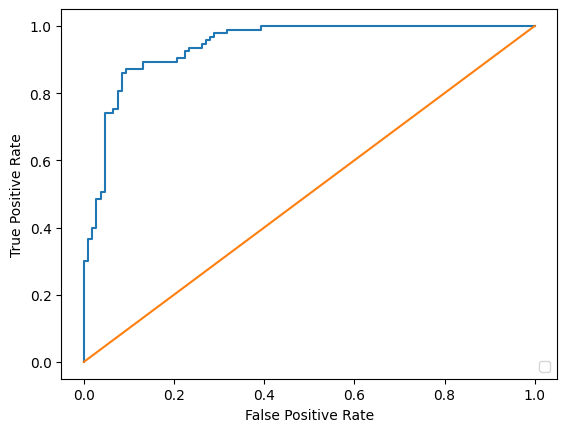

ROC AUC score :        0.9424178474525172


In [23]:
# Training a model with Heteroskedastic loss function without changing delta
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

class HeteroskedasticNN(nn.Module):
      def __init__(self, input_len):
          super(HeteroskedasticNN, self).__init__()
          self.fc1 = nn.Linear(input_len,64)
          self.fc2=nn.Linear(64,64)
          self.mean = nn.Linear(64,1)
          self.log_var = nn.Linear(64,1)
      def forward(self, x):
        x = torch.relu(self.fc1(x))
        x= torch.relu(self.fc2(x))
        mean_pred = self.mean(x)
        log_var_pred = self.log_var(x)
        return mean_pred, log_var_pred

# loss for each sample is:
def heteroskedastic_loss(y_true, y_pred_mean, y_pred_log_var):
      # print("hey", y_true)
      var = torch.exp(y_pred_log_var) # e^log(var)= var!
      loss = 0.5* torch.log(var) + 0.5* ((y_true - y_pred_mean)**2)/var
      return loss.mean()

model = HeteroskedasticNN(input_len=2)
optimizer = optim.Adam(model.parameters(), lr =0.001)

# Function to sample predictions from heteroskedastic outputs
def sample_predictions(mean_pred, log_var_pred, n_samples=100):
    std_dev_pred = torch.exp(0.5 * log_var_pred)  # Convert log-variance to standard deviation
    samples = []
    for _ in range(n_samples):
        sampled_preds = mean_pred + std_dev_pred * torch.randn_like(std_dev_pred)
        sampled_preds = torch.sigmoid(sampled_preds)  # Apply sigmoid to constrain values between 0 and 1
        samples.append(sampled_preds)
    return torch.stack(samples, dim=0).mean(dim=0)  # Return the mean of the samples
model = HeteroskedasticNN(input_len=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
for epoch in range(num_epochs):
      model.train()
      mean_pred, log_var_pred = model(x_train_tensor)
      loss = heteroskedastic_loss(y_train_tensor, mean_pred,log_var_pred)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


model.eval()
with torch.no_grad():
    mean_pred, log_var_pred = model(x_val_tensor)
    sampled_preds = sample_predictions(mean_pred, log_var_pred)
    fpr, tpr, thresholds = roc_curve(y_val_tensor.numpy().reshape(-1), sampled_preds.numpy())
    threshold_index  =    np.argmax(tpr - fpr)
    best_threshold = thresholds[threshold_index]
    print("best threshold found   ", best_threshold)
    roc_auc_val = roc_auc_score(y_val_tensor.numpy().reshape(-1), sampled_preds.numpy())
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1] )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    print ("ROC AUC score :       " , roc_auc_val)

In [24]:
# now I use the best threshold found to test the model

with torch.no_grad():
    mean_pred, log_var_pred = model(x_test_tensor)

    sampled_preds = sample_predictions(mean_pred, log_var_pred)

    y_pred_binary = (sampled_preds >= best_threshold).float()

    y_pred_binary = y_pred_binary.numpy().reshape(-1)
    y_test_tensor = y_test_tensor.numpy().reshape(-1)

    accuracy_delta = accuracy_score(y_test_tensor, y_pred_binary)
    print("Accuracy is :   ", accuracy_delta)

    precision_delta = precision_score(y_test_tensor, y_pred_binary)
    print("precision_score is :   ", precision_delta)

    recall_delta = recall_score(y_test_tensor, y_pred_binary)
    print("recall_score is :   ", recall_delta)

    f1_delta = f1_score(y_test_tensor, y_pred_binary)
    print("f1_score is :   ", f1_delta)

Accuracy is :    0.86
precision_score is :    0.7659574468085106
recall_score is :    0.9230769230769231
f1_score is :    0.8372093023255814
